In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from subprocess import check_call

import cftime
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cesm_tools

In [3]:
USER = os.environ['USER']
datadir = f"/glade/work/{USER}/cam-sd-cases/data/amelia-proposed"
os.makedirs(datadir, exist_ok=True)

In [4]:
waypoints_csv = f'{datadir}/Full_Mission.csv'

if not os.path.exists(waypoints_csv):
    waypoints_url = 'https://archive.eol.ucar.edu/homes/stephens/FLTPLAN/AMELiA/Full_Mission.csv'
    check_call(['wget', waypoints_url], cwd=datadir)
    
df = pd.read_csv(waypoints_csv, skipinitialspace=True)
df

,Waypoint #,Waypoint Name,Altitude (ft),Latitude (hDDMM),Longitude (hDDDMM),Segment Time (Min),Flight Time (HH:MM),Segment Distance (nmi),Flight Distance (nmi),Segment Fuel (lbs),Fuel Remaining (lbs),Phase
0,1,KBJC,5673,n3955,w10507,0.0,00:00,0,0,0,37000,FF01
1,2,NaN,37000,n4139,w10624,20.9,00:21,120,120,1382,35618,FF01
2,3,KGTF,3480,n4729,w11122,61.4,01:22,409,529,3577,32041,FF01
3,4,NaN,3480,n4743,w11143,5.0,01:27,20,549,404,31636,FF01
4,5,NaN,39000,n4919,w11407,23.7,01:51,135,684,1567,30069,FF01
...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,NaN,39000,n5215,w11916,24.3,46:16,138,16298,1622,-143361,FF02
152,153,KGTF,3480,n4729,w11122,61.5,47:18,418,16716,3522,-146883,FF02
153,154,NaN,3480,n4712,w11106,5.0,47:23,20,16736,404,-147287,FF02
154,155,NaN,41000,n4509,w10914,25.0,47:48,145,16882,1635,-148922,FF02


In [5]:
latitude = np.empty((len(df)))                   
for i, x in enumerate(df['Latitude (hDDMM)']):
    assert x[0] in ['n', 's']
    sign = 1.0 if x[0] == 'n' else -1.0
    degrees = np.float64(x[1:3])
    minutes = np.float64(x[3:5])
    latitude[i] = sign * degrees + minutes / 60.0

longitude = np.empty((len(df)))                       
for i, x in enumerate(df['Longitude (hDDDMM)']):
    assert x[0] in ['w', 'e']
    sign = 1.0 if x[0] == 'e' else -1.0
    degrees = np.float64(x[1:4])
    minutes = np.float64(x[4:6])
    longitude[i] = sign * degrees + minutes / 60.0

In [6]:
with xr.open_dataset('data/cam_grid.0.9x1.25.nc') as grid_coords:
    grid_coords = grid_coords.load()
grid_coords

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, lev: 56, ilev: 57)
Coordinates: (12/15)
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    gw       (lat) float64 3.382e-05 0.0002705 0.000541 ... 0.0002705 3.382e-05
  * lev      (lev) float64 1.868 2.353 2.948 3.677 ... 947.5 962.5 977.5 992.5
    hyam     (lev) float64 0.001868 0.002353 0.002948 ... 0.003321 2.402e-05
    hybm     (lev) float64 0.0 0.0 0.0 0.0 0.0 ... 0.9311 0.9526 0.9742 0.9925
    ...       ...
    hybi     (ilev) float64 0.0 0.0 0.0 0.0 0.0 ... 0.9419 0.9634 0.985 1.0
    ndbase   int32 0
    nsbase   int32 0
    nbdate   int32 20160101
    nbsec    int32 0
    mdt      int32 1800
Data variables:
    *empty*
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              cam6327_sd.apo_test_srf_emis.003
    logname:           mclong
    host:              cheyenne4
    initial_file:      /glade/work/mclong/cam-sd-cases/data/f.e20.FWAMIP.f09_...
    topography_file:   /glade/work/tilmes/inputdata/topo/fv_0.9x1.25_nc3000_N...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_6

In [7]:
amelia_lon = 360.0 - 150.0

sathist_lat = grid_coords.sel(lon=amelia_lon, lat=slice(-6, 90)).lat.values
sathist_lon = grid_coords.sel(lon=amelia_lon).lon.values * np.ones(len(sathist_lat))

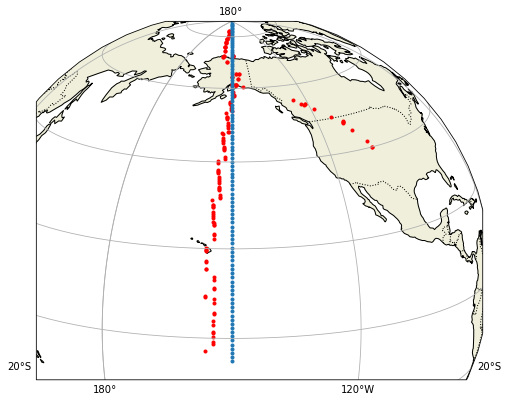

In [8]:
fig, ax = plt.subplots(
    figsize=(8, 8), 
    subplot_kw=dict(projection=ccrs.Orthographic(-150, 15)),
)
ax.set_extent(
    [-200, -70, -10, 90], 
    crs=ccrs.PlateCarree(),
)

ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.plot(longitude, latitude, 'r.', transform=ccrs.PlateCarree())

ax.plot(sathist_lon, sathist_lat, '.', transform=ccrs.PlateCarree());

In [9]:
dates = xr.cftime_range('1986-01-01', '2020-12-31', freq='5D', calendar='noleap')
dates

CFTimeIndex([1986-01-01 00:00:00, 1986-01-06 00:00:00, 1986-01-11 00:00:00,
             1986-01-16 00:00:00, 1986-01-21 00:00:00, 1986-01-26 00:00:00,
             1986-01-31 00:00:00, 1986-02-05 00:00:00, 1986-02-10 00:00:00,
             1986-02-15 00:00:00,
             ...
             2020-11-12 00:00:00, 2020-11-17 00:00:00, 2020-11-22 00:00:00,
             2020-11-27 00:00:00, 2020-12-02 00:00:00, 2020-12-07 00:00:00,
             2020-12-12 00:00:00, 2020-12-17 00:00:00, 2020-12-22 00:00:00,
             2020-12-27 00:00:00],
            dtype='object', length=2555, calendar='noleap', freq='5D')

In [10]:
time = xr.DataArray(
    [cftime.datetime(d.year, d.month, d.day, calendar='gregorian') for d in dates],
    dims=('time'),
)
time

<xarray.DataArray (time: 2555)>
array([cftime.datetime(1986, 1, 1, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(1986, 1, 6, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(1986, 1, 11, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       ...,
       cftime.datetime(2020, 12, 17, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(2020, 12, 22, 0, 0, 0, 0, calendar='standard', has_year_zero=False),
       cftime.datetime(2020, 12, 27, 0, 0, 0, 0, calendar='standard', has_year_zero=False)],
      dtype=object)
Dimensions without coordinates: time

In [11]:
time_components = cesm_tools.gen_time_components_variable(time)
time_components

<xarray.DataArray 'time_components' (time: 2555, n_time_components: 6)>
array([[1.986e+03, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.986e+03, 1.000e+00, 6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.986e+03, 1.000e+00, 1.100e+01, 0.000e+00, 0.000e+00, 0.000e+00],
       ...,
       [2.020e+03, 1.200e+01, 1.700e+01, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.020e+03, 1.200e+01, 2.200e+01, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.020e+03, 1.200e+01, 2.700e+01, 0.000e+00, 0.000e+00, 0.000e+00]])
Coordinates:
  * time     (time) object 1986-01-01 00:00:00 ... 2020-12-27 00:00:00
Dimensions without coordinates: n_time_components
Attributes:
    long_name:  time components (year, month, day, hour, min, sec)
    units:      none

In [12]:
dso = xr.Dataset(dict(
    time=time,
    time_component=time_components,
    latitude=sathist_lat,
    longitude=sathist_lon,
))
dso

<xarray.Dataset>
Dimensions:         (time: 2555, n_time_components: 6, latitude: 102, longitude: 102)
Coordinates:
  * time            (time) object 1986-01-01 00:00:00 ... 2020-12-27 00:00:00
  * latitude        (latitude) float64 -5.183 -4.241 -3.298 ... 88.12 89.06 90.0
  * longitude       (longitude) float64 210.0 210.0 210.0 ... 210.0 210.0 210.0
Dimensions without coordinates: n_time_components
Data variables:
    time_component  (time, n_time_components) float64 1.986e+03 1.0 ... 0.0 0.0

In [16]:
file_out = f'{datadir}/co2_amelia-ish_150W_nday5.nc'

cesm_tools.to_netcdf_clean(dso, file_out)

------------------------------
Writing /glade/work/mclong/cam-sd-cases/data/amelia-proposed/co2_amelia-ish_150W_nday5.nc

netcdf co2_amelia-ish_150W_nday5 {
dimensions:
	latitude = 102 ;
	longitude = 102 ;
	time = 2555 ;
	n_time_components = 6 ;
variables:
	double latitude(latitude) ;
	double longitude(longitude) ;
	int time(time) ;
		time:units = "days since 1986-01-01 00:00:00.000000" ;
		time:calendar = "standard" ;
	int time_component(time, n_time_components) ;
		time_component:_FillValue = -2147483647 ;
		time_component:long_name = "time components (year, month, day, hour, min, sec)" ;
		time_component:units = "none" ;

// global attributes:
		:history = "Tue May 24 06:34:06 2022: ncks -O --fl_fmt=64bit_offset /glade/work/mclong/cam-sd-cases/data/amelia-proposed/co2_amelia-ish_150W_nday5.nc /glade/work/mclong/cam-sd-cases/data/amelia-proposed/co2_amelia-ish_150W_nday5.nc" ;
		:NCO = "netCDF Operators version 5.0.3 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)" ;